In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.linalg import sqrtm

from data_collector import Omie

from ml import GaussianKernel, ComputationMode, load_kernels_dict
from plot import ImperialColors, get_continuous_cmap
from potenciala import BucketMethod, FigureShape, SingleTimeSeries, VectorTimeSeries
from stochastic import (EulerMaruyama, ConstantDiffusionMultivariate, SpatialDifferenceDriftMultivariate, 
                        SpatialDiffusionUnivariate, SpatialDriftMultivariate, SpatialNearestDriftMultivariate)

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [5]:
# filter data before 2004 (missing dates in 2003) and beyond 2021
df = df_raw.query("year >= 2004 & year <= 2020")

### Univariate timeseries

In [ ]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

In [ ]:
s_1.plot_ts()

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

In [ ]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

In [ ]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [ ]:
a = s_1.drift.mean["drift_1"]
a = a.reindex(np.arange(0, a.index.max() + 20)).fillna(0)
b = s_1.diffusion.mean["diffusion_1"]
b = b.reindex(np.arange(0, b.index.max() + 20)).fillna(0)

x_df = s_1.df[(s_1.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[0]

In [ ]:
drift = SpatialDriftMultivariate(df=a.to_frame())
diffusion = SpatialDiffusionUnivariate(df=b.to_frame())

em_1 = EulerMaruyama(num_sim=1000, period=24*6, delta_t=1, nu=0, drift=drift, diffusion=diffusion)

In [ ]:
sim_df = em_1.simulate(x0=np.array([x_0]), random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[:,  :em_1.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Multivariate  timeseries $D_{1}^i(x)$ 

In [10]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

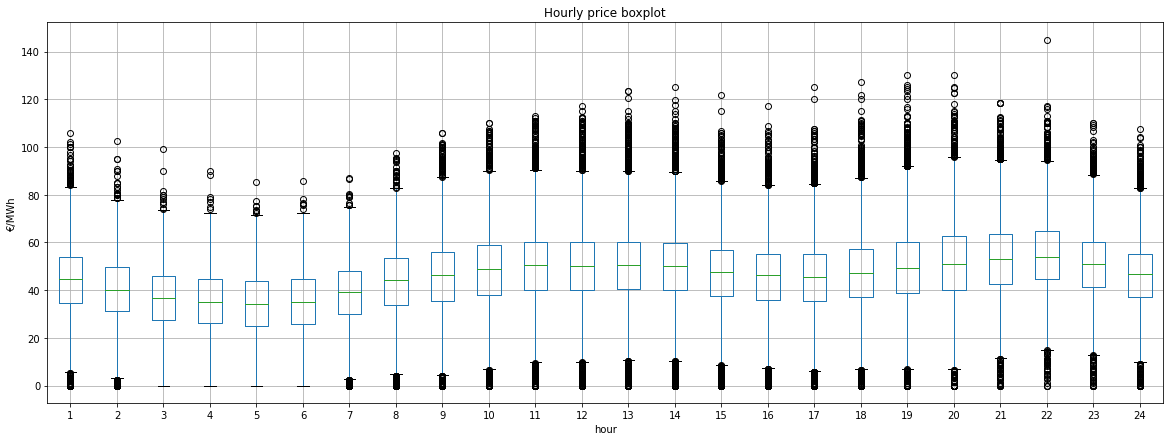

In [11]:
s.plot_hourly_boxplot()

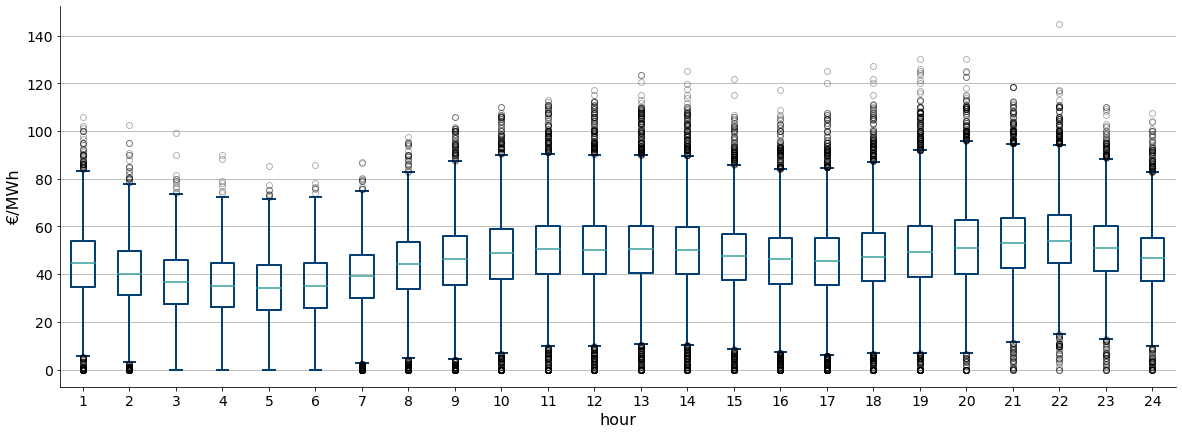

In [12]:
boxprops = dict(linewidth=2, color=ImperialColors.blue.value)
capprops = dict(linewidth=2, color=ImperialColors.blue.value)
whiskerprops = dict(linewidth=2, color=ImperialColors.blue.value)
medianprops = dict(linewidth=1.5, color=ImperialColors.seaglass.value)
flierprops = dict(alpha=0.3, color=ImperialColors.cool_grey.value)


fig, ax = plt.subplots(figsize=(20, 7))
s.df_vector.T.boxplot(ax=ax, boxprops=boxprops, 
                      medianprops=medianprops, whiskerprops=whiskerprops, 
                      flierprops=flierprops, capprops=capprops)
ax.set_xlabel("hour", fontsize=16)
ax.set_ylabel("€/MWh", fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(visible=False, axis="x")
ax.tick_params(axis='both', labelsize=14)
fig.savefig("figures/paper/hourly_boxplot.pdf", bbox_inches='tight')

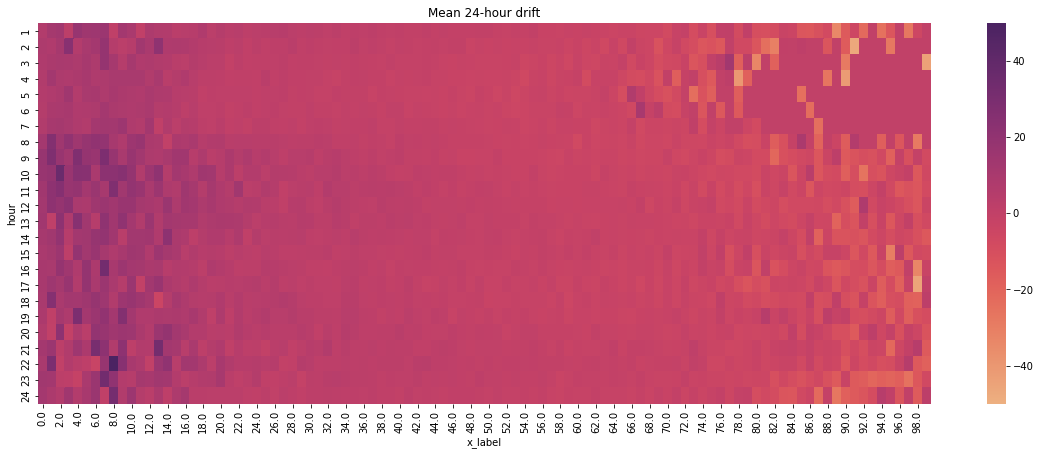

In [13]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-50, vmax=50)
ax.set_title("Mean 24-hour drift")
fig.show()

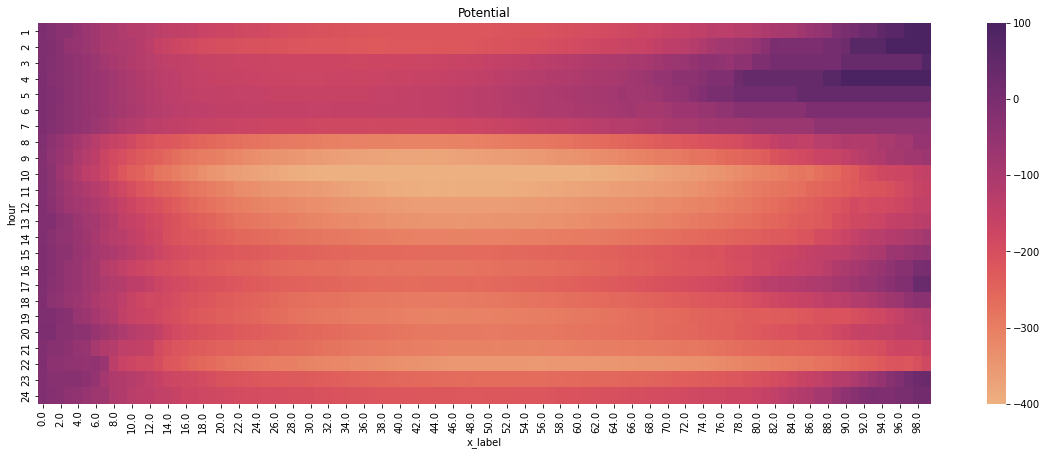

In [14]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-400, vmax=100)
ax.set_title("Potential")
fig.show()

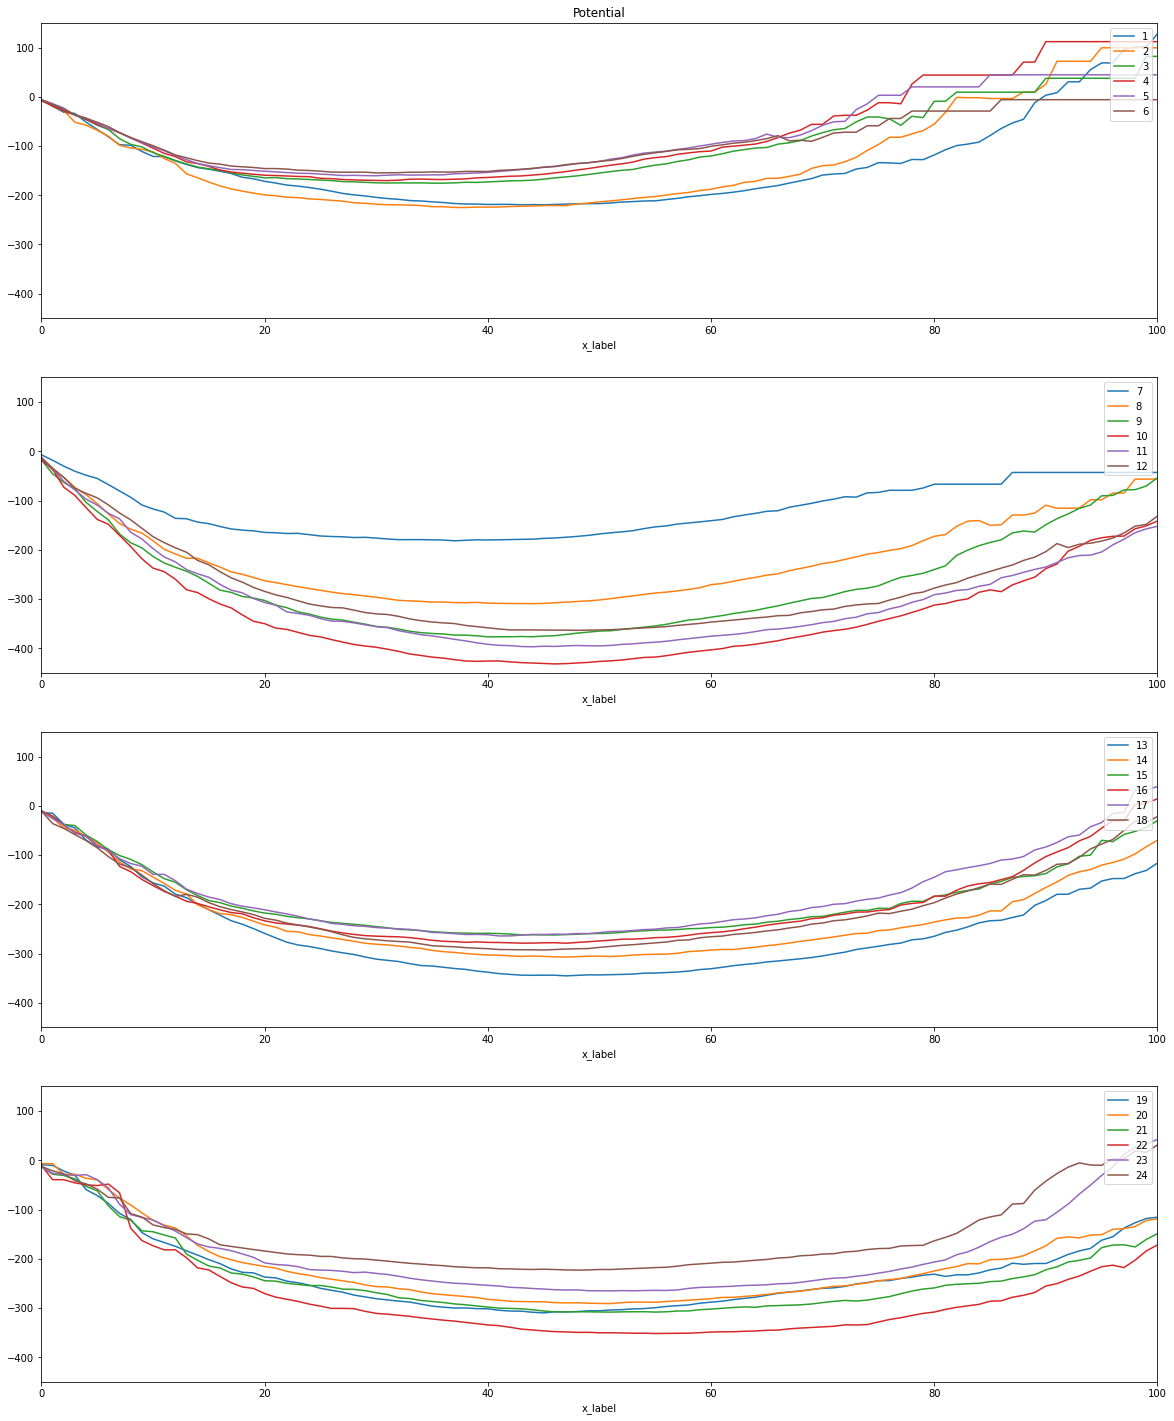

In [15]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 100)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

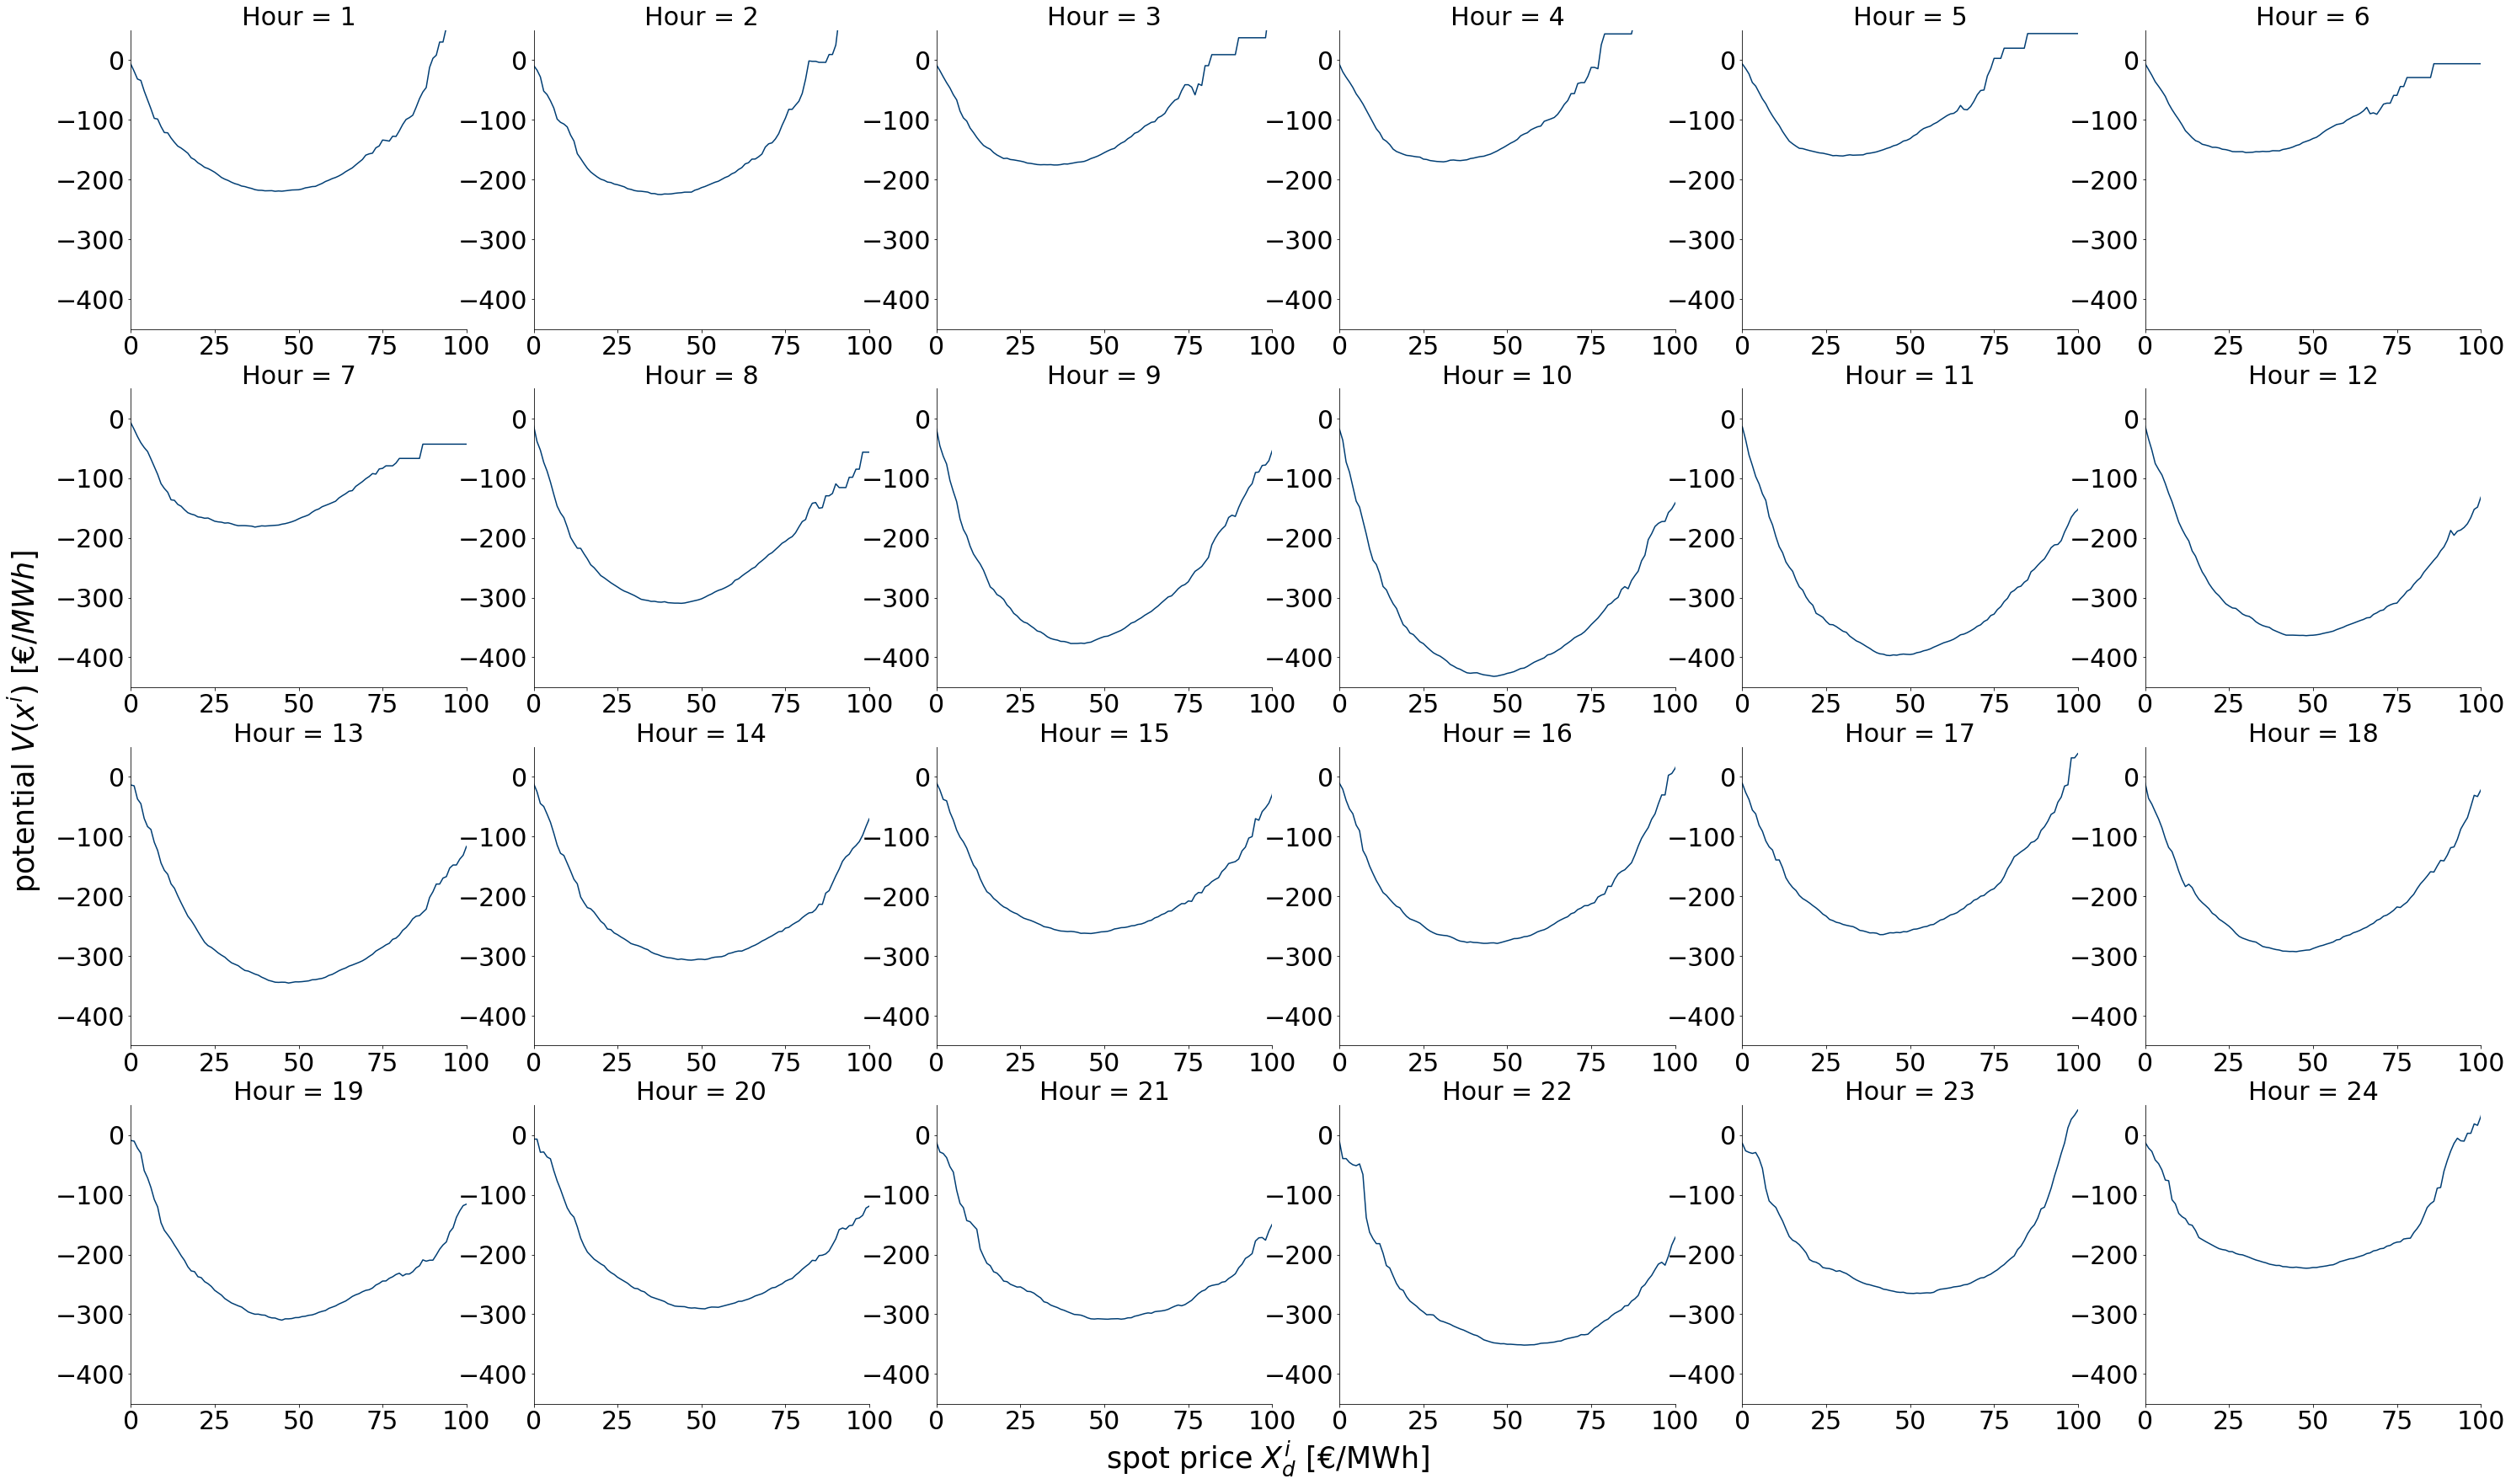

In [16]:
fig, axis = plt.subplots(4, 6, figsize=(50, 30))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s.potential_hour_x.loc[h].plot(ax=ax, lw=1.5, color=ImperialColors.blue.value)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(0, 100)
        ax.set_ylim(-450, 50)
        ax.tick_params(axis='both', labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price $X_{d}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 35})
fig.text(0.09, 0.5, "potential $V(x^{i})$ $[€/MWh]$", ha="center", va="center",
         fontdict={"size": 35}, rotation=90)
fig.savefig("figures/paper/potential_matrix.pdf", bbox_inches='tight')

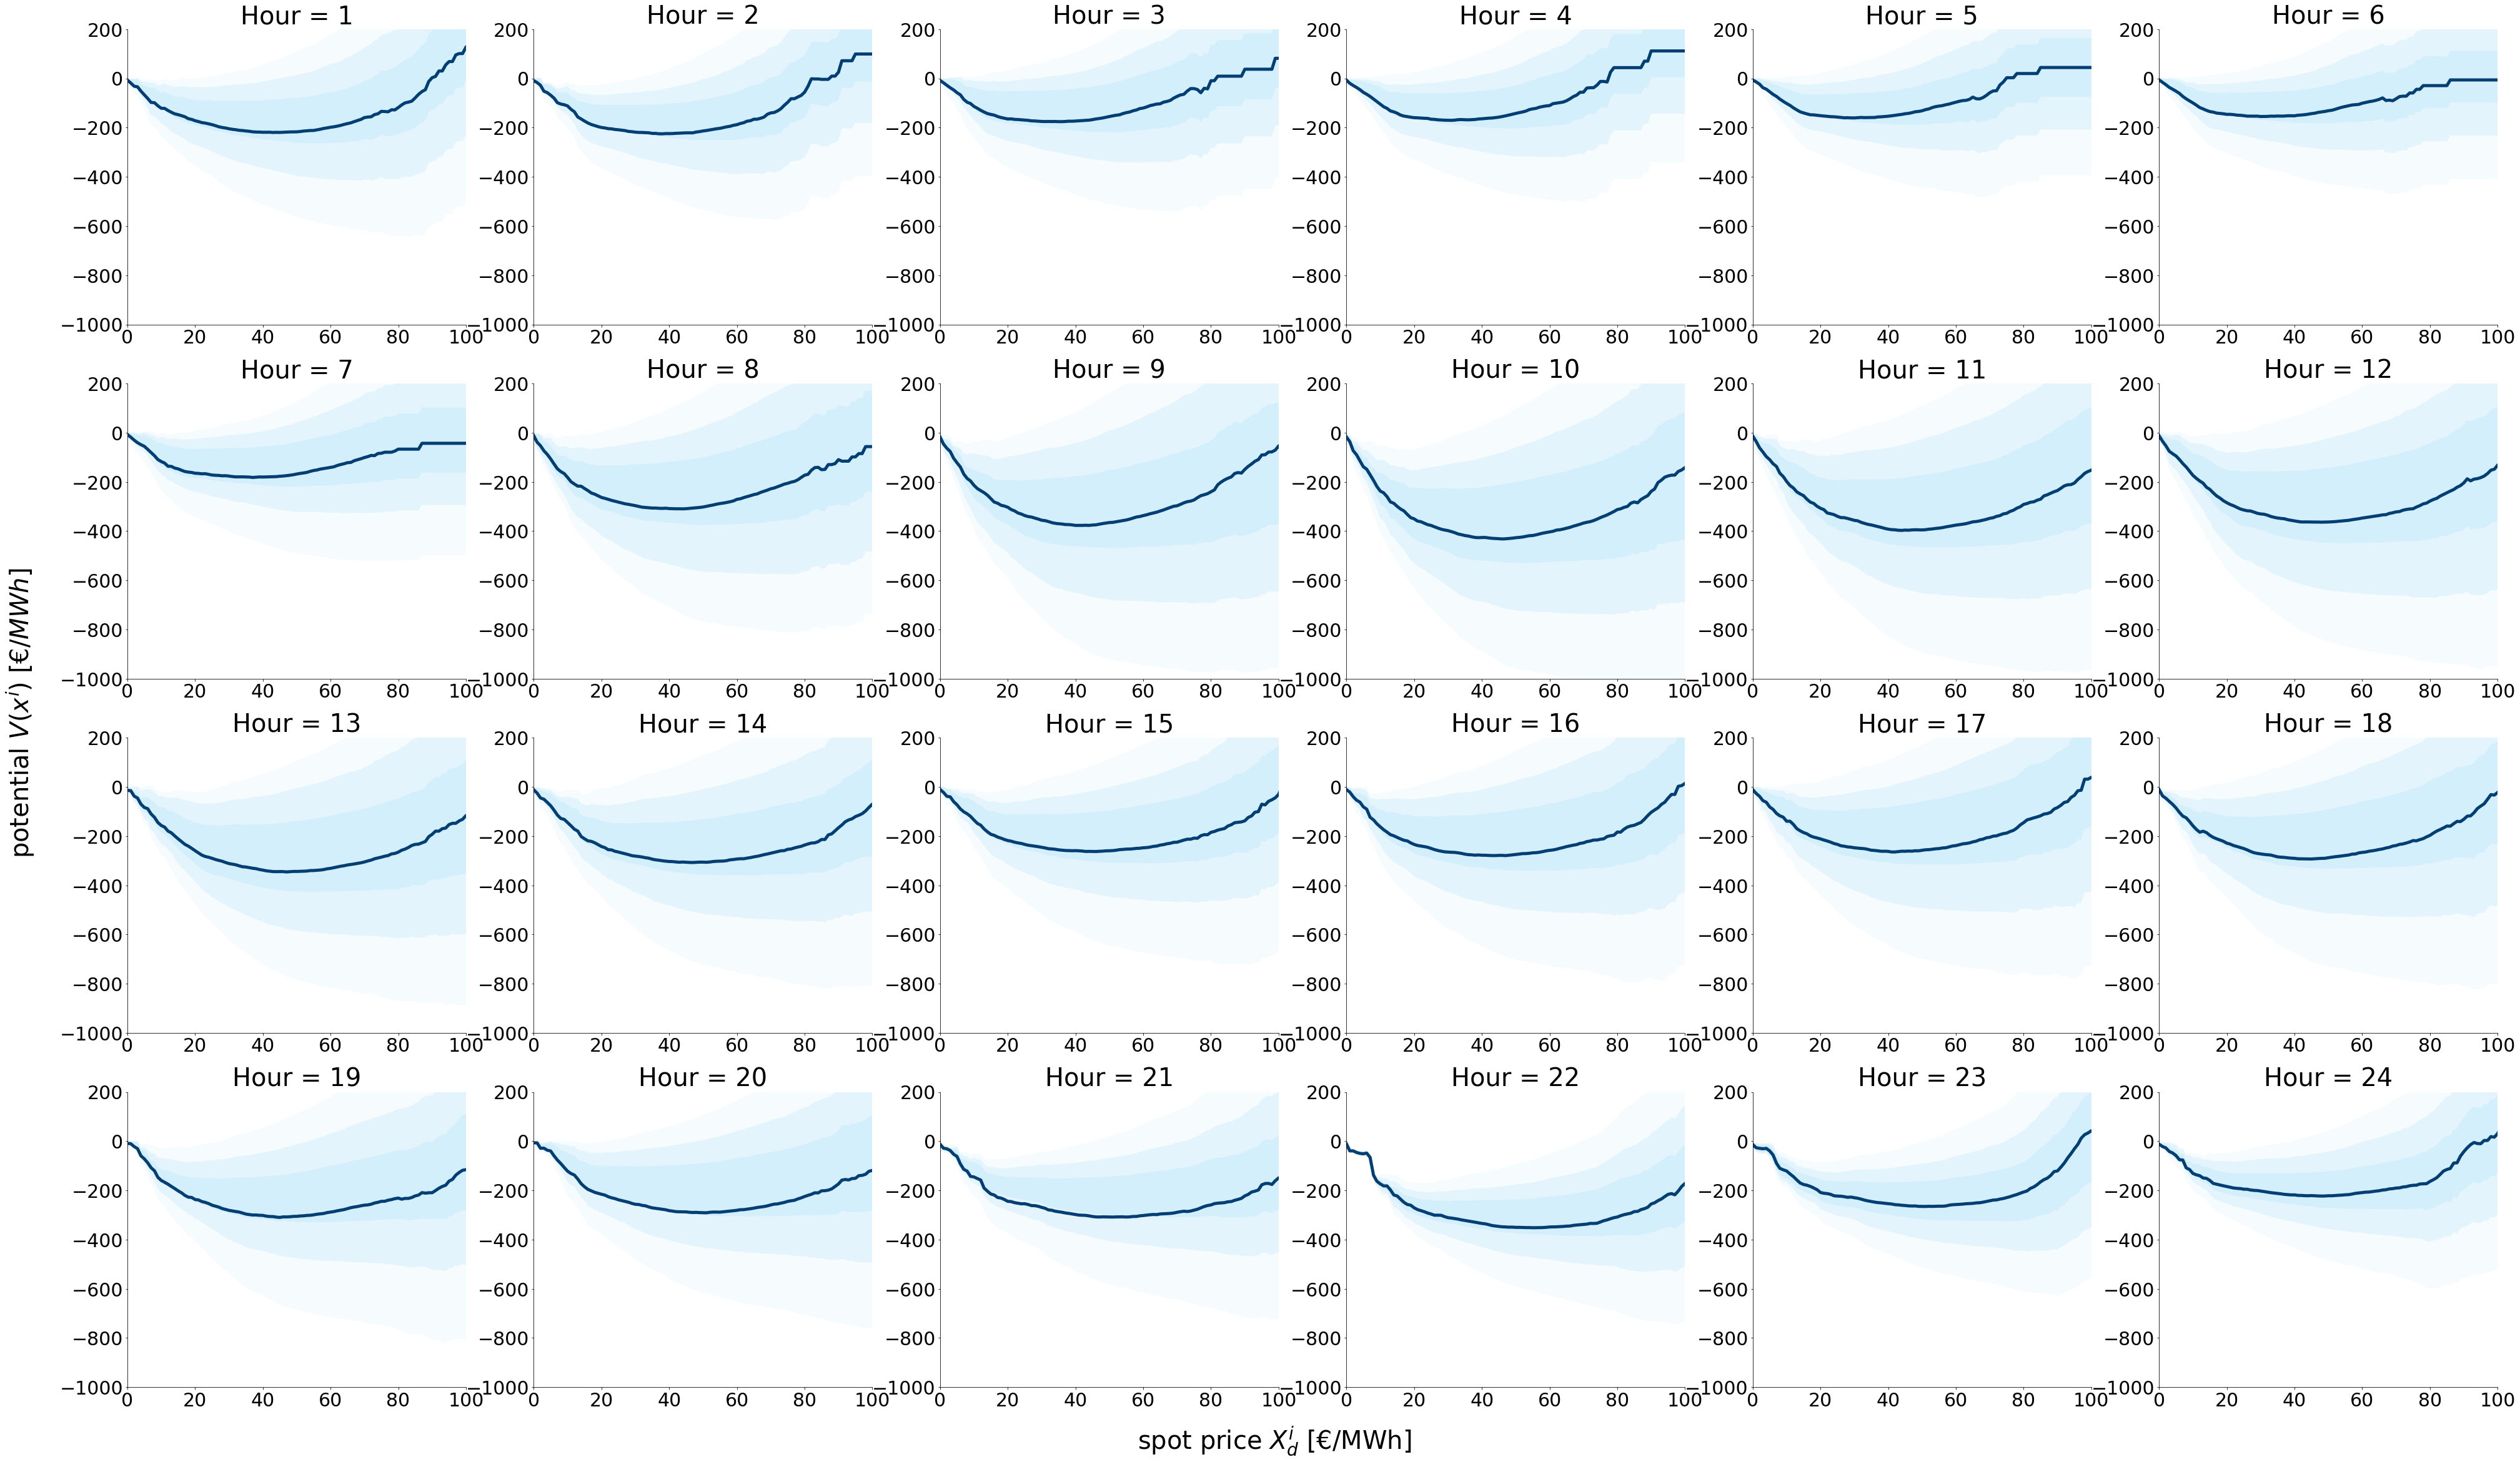

In [17]:
fig, axis = plt.subplots(4, 6, figsize=(68, 40))
percentiles_alpha = [0.2, 0.5, 1]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s.potential_hour_x.loc[h].plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                    s.potential_percentile_hour_x.columns, 
                    s.potential_percentile_hour_x.loc[h, s.drift_quantile[k]], 
                    s.potential_percentile_hour_x.loc[h, s.drift_quantile[-k-1]],
                    facecolor=ImperialColors.light_blue.value, alpha=alpha_value)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 100)
        ax.set_ylim(-1000, 200)
        ax.tick_params(axis='both', labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price $X_{d}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 40})
fig.text(0.09, 0.5, "potential $V(x^{i})$ $[€/MWh]$", ha="center", va="center",
         fontdict={"size": 40}, rotation=90)
fig.savefig("figures/paper/potential_matrix_two_percentiles.pdf", bbox_inches='tight')

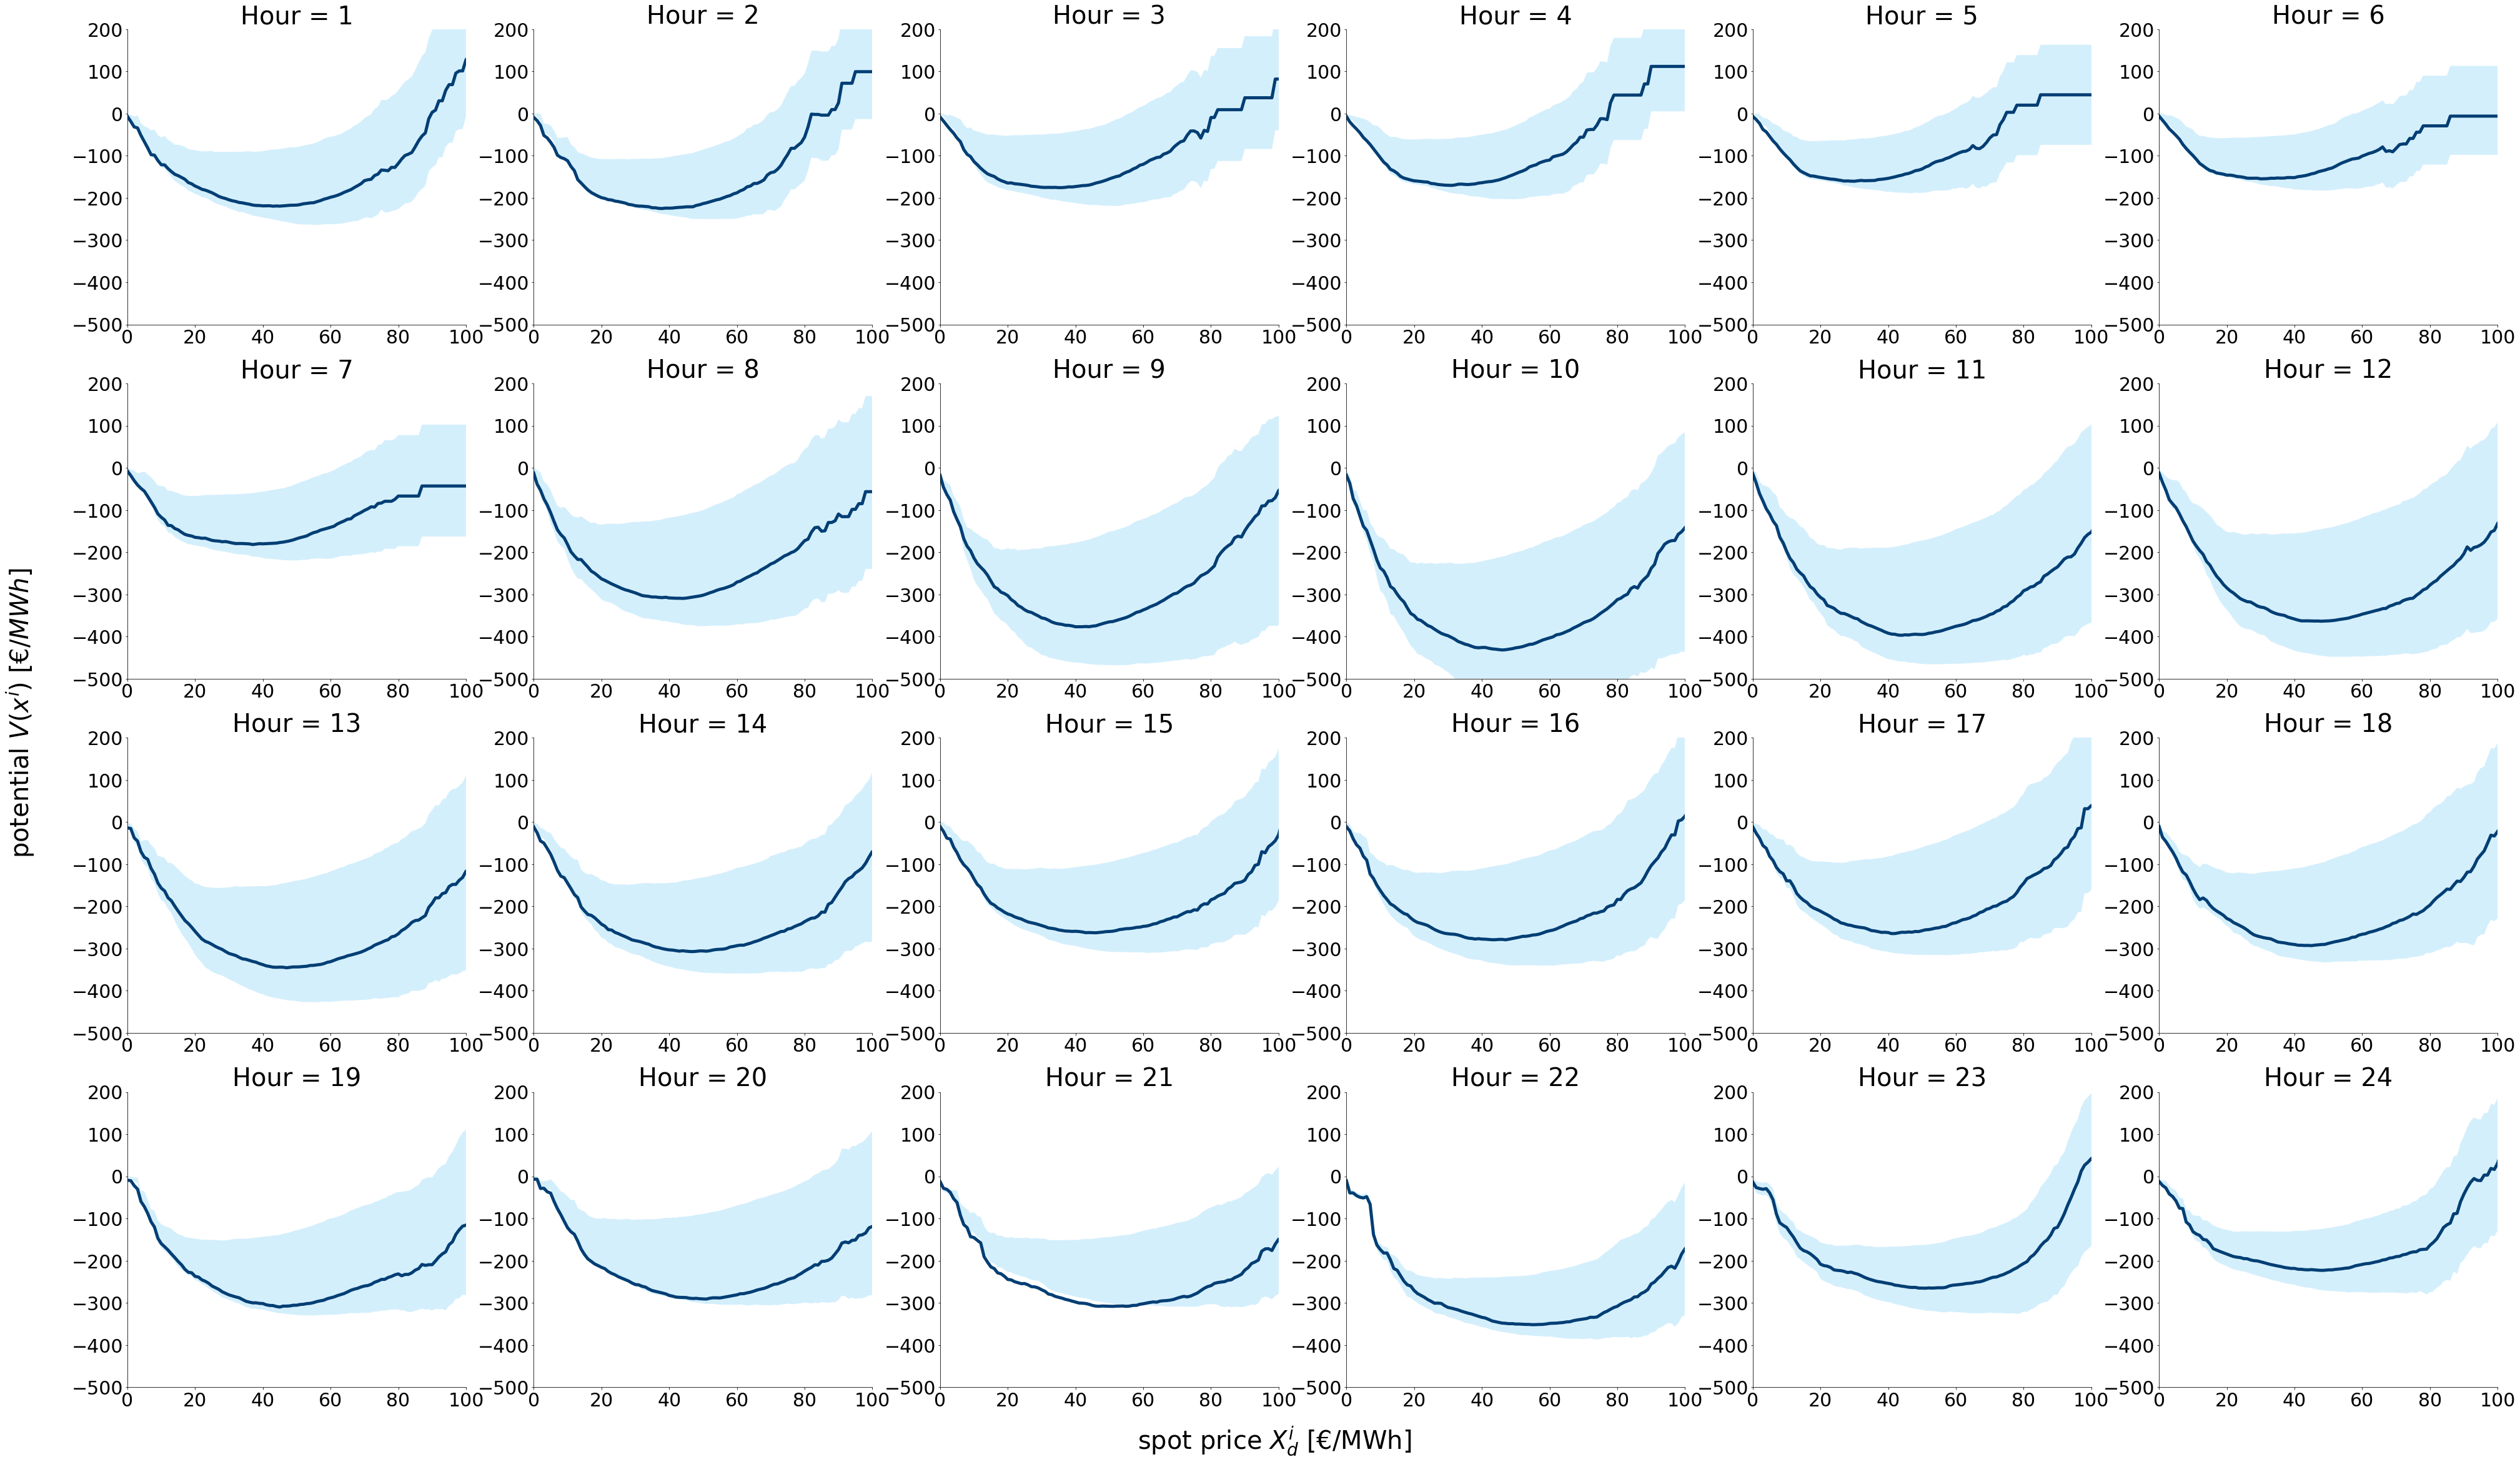

In [18]:
fig, axis = plt.subplots(4, 6, figsize=(68, 40))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s.potential_hour_x.loc[h].plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        ax.fill_between(
                s.potential_percentile_hour_x.columns, 
                s.potential_percentile_hour_x.loc[h, 0.4], 
                s.potential_percentile_hour_x.loc[h, 0.6],
                facecolor=ImperialColors.light_blue.value, alpha=1)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 100)
        ax.set_ylim(-500, 200)
        ax.tick_params(axis='both', labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price $X_{d}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 40})
fig.text(0.09, 0.5, "potential $V(x^{i})$ $[€/MWh]$", ha="center", va="center",
         fontdict={"size": 40}, rotation=90)
fig.savefig("figures/paper/potential_matrix_one_percentile.pdf", bbox_inches='tight')

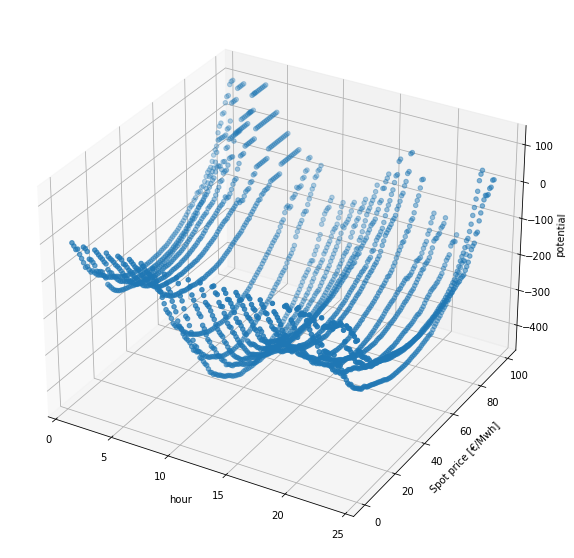

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s.potential_hour_x.iloc[:, :100].stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("Spot price [€/Mwh]")
ax.set_zlabel("potential")
fig.show()

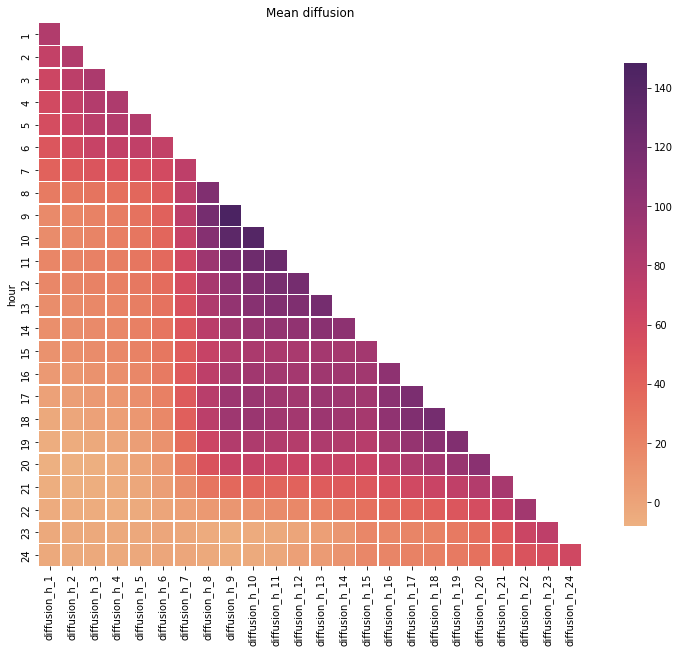

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

In [21]:
cmap_1 = get_continuous_cmap([ImperialColors.cool_grey.value,
                              ImperialColors.seaglass.value,
                              ImperialColors.blue.value])
cmap_2 = get_continuous_cmap([ImperialColors.cool_grey.value,
                              ImperialColors.light_blue.value,
                              ImperialColors.blue.value])
cmap_3 = get_continuous_cmap([ImperialColors.blue.value,
                              ImperialColors.seaglass.value, 
                              ImperialColors.cool_grey.value])
cmap_4 = get_continuous_cmap([ImperialColors.light_blue.value, 
                              ImperialColors.blue.value])
cmap_5 = get_continuous_cmap([ImperialColors.seaglass.value,
                              ImperialColors.blue.value])
cmap_6 = get_continuous_cmap([ImperialColors.blue.value,
                              ImperialColors.light_blue.value])

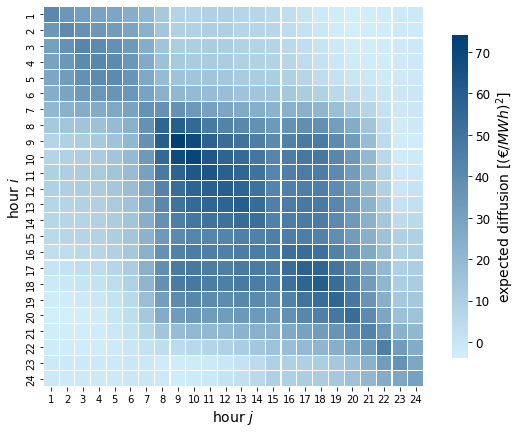

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
aux_diff_matrix = s.diffusion_matrix.copy(deep=True)
aux_diff_matrix = aux_diff_matrix*1/2
aux_diff_matrix.columns = aux_diff_matrix.index
sns.heatmap(aux_diff_matrix, cmap=cmap_4, square=True, linewidths=0.1, 
            cbar_kws={"shrink": 0.85}, ax=ax)
ax.collections[0].colorbar.set_label('expected diffusion [$(€/MWh)^2$]', fontsize=14)
ax.collections[0].colorbar.ax.tick_params(labelsize=12) 
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel("hour $j$", fontsize=14)
ax.set_ylabel("hour $i$", fontsize=14)
fig.savefig("figures/paper/diffusion_matrix.pdf", bbox_inches='tight')

In [23]:
aux_diff_matrix.loc[7:11, 7:11]

hour         7          8          9          10         11
hour                                                       
7     36.574782  37.095729  37.156504  33.847713  29.981160
8     37.095729  56.564895  60.007848  55.106110  47.406111
9     37.156504  60.007848  74.084509  68.008787  58.205846
10    33.847713  55.106110  68.008787  70.910699  62.254129
11    29.981160  47.406111  58.205846  62.254129  63.368750

In [24]:
aux_diff_matrix.max().max()

74.08450889372666

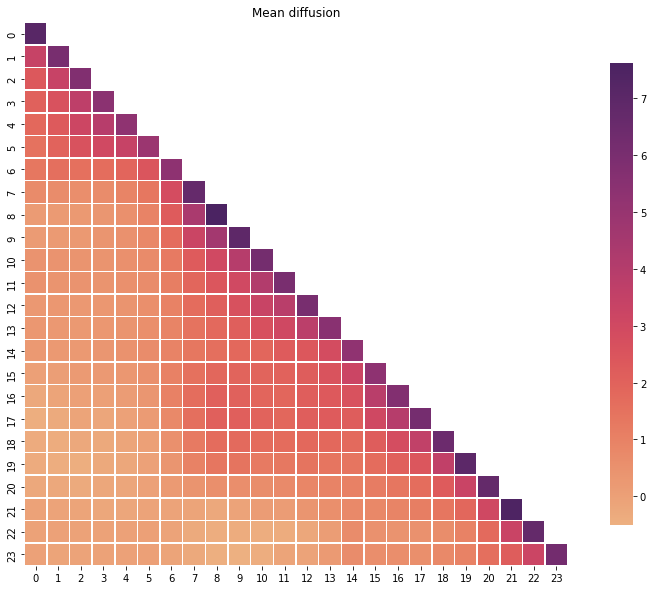

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.sqrt_diff_matrix, dtype=bool), k=1)
sns.heatmap(s.sqrt_diff_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^i(x)$ and diagonal $D_{2}^{ii}$

In [77]:
def fill_ax_simulation(ax: plt.Axes, sim_dict: dict()):
    
    sim_df = sim_dict["sim_df"]
    actual_df = sim_dict["actual_df"]
    num_sim_show = sim_dict.get("num_sim_show", 0)
    quantile_regions = sim_dict.get("quantile_regions", True)
    ymax = sim_dict.get("ymax", None)
    
    if num_sim_show > 0:
        sim_df.iloc[24:, : num_sim_show].plot(alpha=0.05, ax=ax, legend=False)
    
    sim_df.mean(axis=1).plot(lw=2, color=ImperialColors.blue.value, ax=ax)
    actual_df.reset_index()["spain"].plot(lw=2, color=ImperialColors.dark_grey.value, ax=ax)
    intervals_df = sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1)
    
    if quantile_regions:
        ax.fill_between(intervals_df.columns, intervals_df.iloc[0, :], intervals_df.iloc[-1, :],
                   facecolor=ImperialColors.light_blue.value, alpha=0.5)
        ax.fill_between(intervals_df.columns, intervals_df.iloc[1, :], intervals_df.iloc[-2, :],
                   facecolor=ImperialColors.light_blue.value, alpha=1)
    
    ax.set_xlabel("time [hours]", fontsize=14)
    ax.set_ylabel("spot price [€/MWh]", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if ymax:
        ax.set_ylim(0, ymax)

        
def plot_simulation(sim_dict: dict(), filename: str = None):
    
    fig, ax = plt.subplots(1,1, figsize=(15, 10))
    fill_ax_simulation(ax=ax, sim_dict=sim_dict)

    if filename:
        fig.savefig(filename, bbox_inches='tight')
        
def plot_simulation_comparison(sim_left_dict: dict(), sim_right_dict: dict(), filename: str = None):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
    
    fill_ax_simulation(ax=ax0, sim_dict=sim_left_dict)
    ax0.set_title(sim_left_dict.get("title", ""), fontsize=16)
    fill_ax_simulation(ax=ax1, sim_dict=sim_right_dict)
    ax1.set_title(sim_right_dict.get("title", ""), fontsize=16)
    
    if filename:
        fig.savefig(filename, bbox_inches='tight')
    

In [27]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [28]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
diag_diff_matrix = pd.DataFrame(np.sqrt(np.diag(np.diag(s.diffusion_matrix))))
diag_diffusion = ConstantDiffusionMultivariate(df=diag_diff_matrix)

em_2 = EulerMaruyama(num_sim=1000, periods=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=diag_diffusion)

In [29]:
sim_df = em_2.simulate(x0=x_0, random_seed=124)

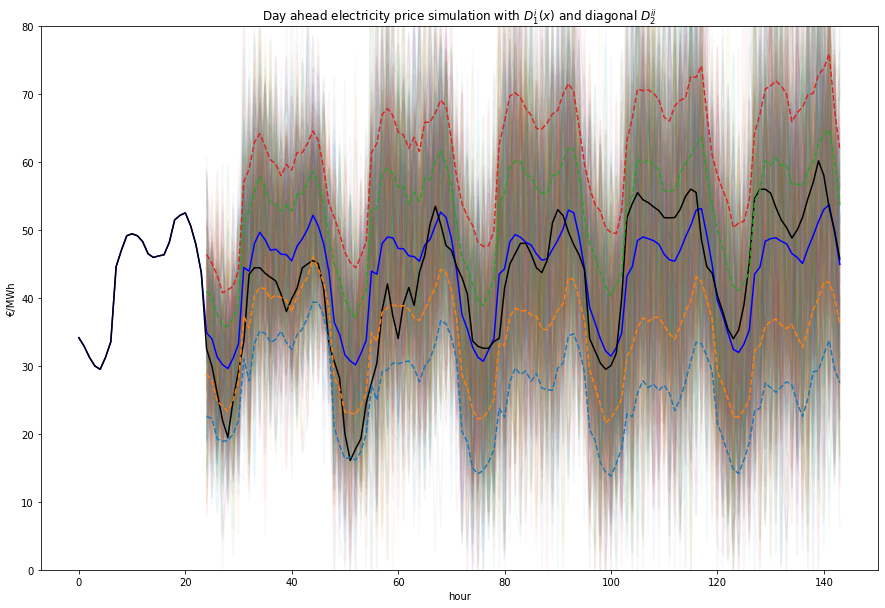

In [30]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_2.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="blue", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="black", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^{i}(x)$ and diagonal $D_2^{ii}$")
plt.show()

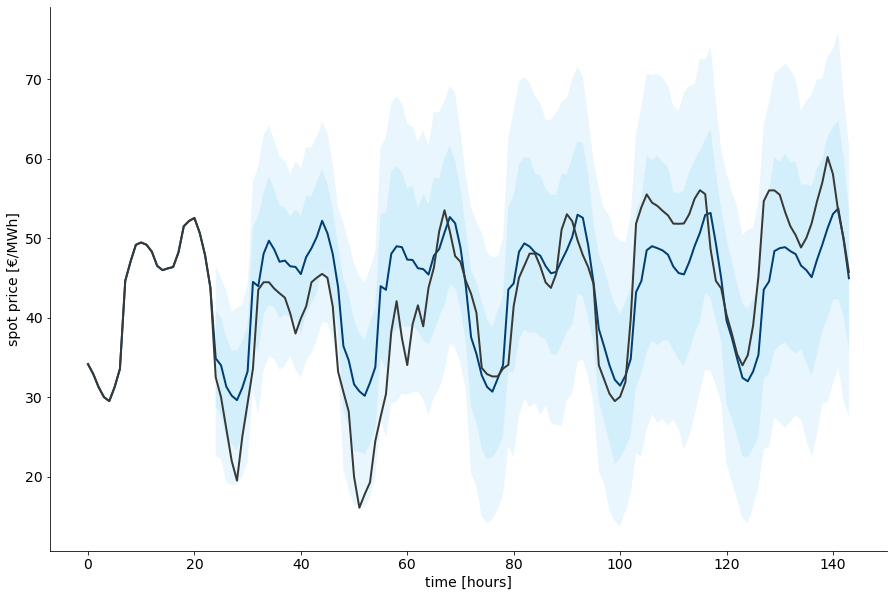

In [31]:
sim_dict = {"sim_df": sim_df, "actual_df": x_df}
plot_simulation(sim_dict=sim_dict)

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$

In [94]:
#x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_df = df_raw[df_raw["year"] == 2021].iloc[:24*6]
x_df_km = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

In [95]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrtm(1/2*s.diffusion_matrix)))

em_3 = EulerMaruyama(num_sim=1000, periods=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=cte_diffusion)

In [96]:
sim_df = em_3.simulate(x0=x_0, random_seed=124)
sim_df_km = sim_df.copy(deep=True)

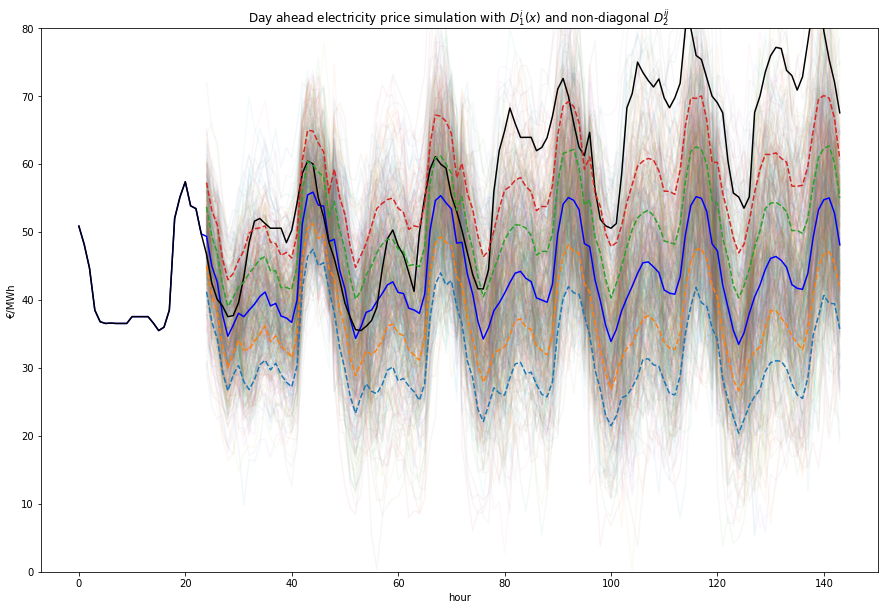

In [97]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_3.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="blue", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="black", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

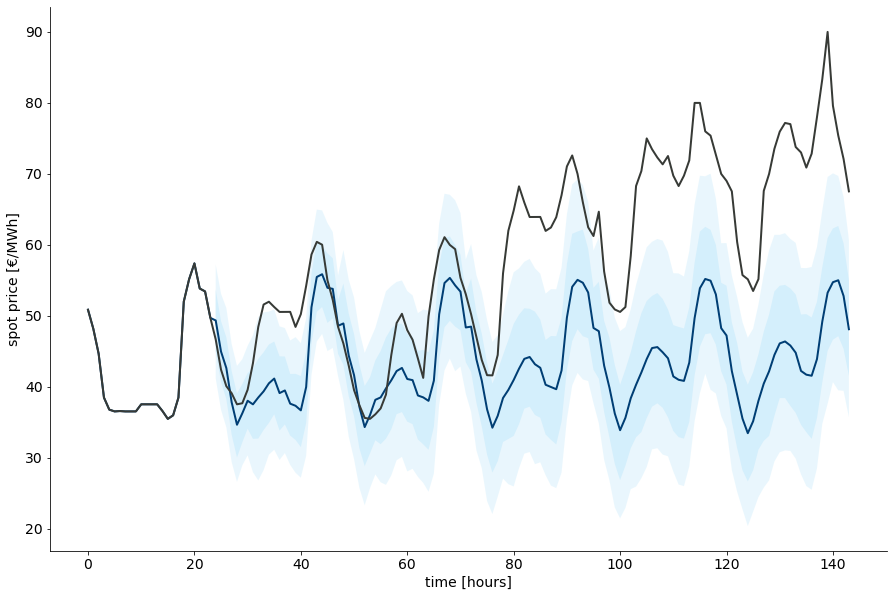

In [98]:
sim_dict_km = {"sim_df": sim_df_km, "actual_df": x_df_km}
plot_simulation(sim_dict=sim_dict_km)

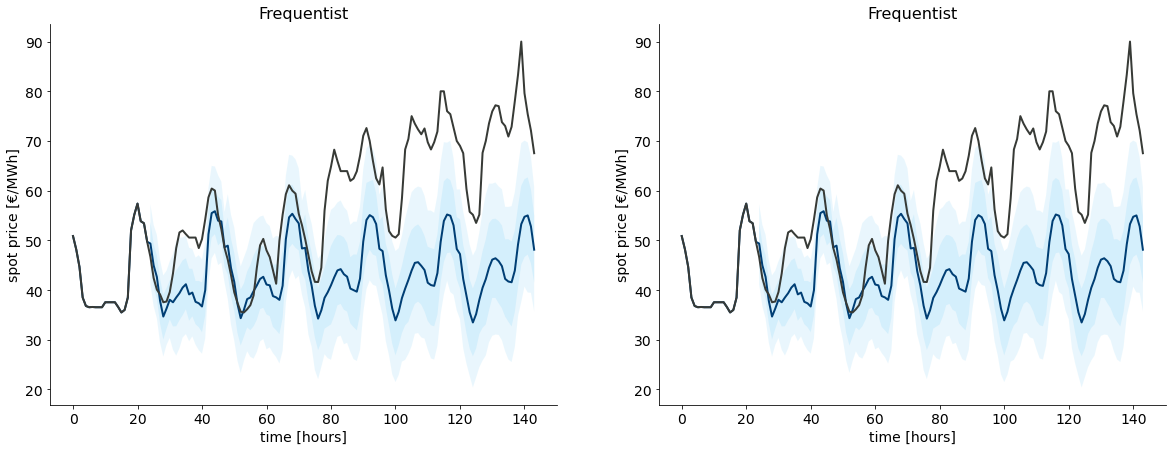

In [99]:
sim_dict_km = {"sim_df": sim_df_km, "actual_df": x_df_km, "title": "Frequentist"}
plot_simulation_comparison(sim_left_dict=sim_dict_km, sim_right_dict=sim_dict_km)
                           #filename="figures/paper/em_km_large_timestep.pdf")

### Multivariate timeseries  - $D_{1}^{i}(X_{d}^i - X_{d-1}^i)$ 

In [ ]:
s_back_drift = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, x_transformation="back_drift")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.samples_hour_x.iloc[:, :200], ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Samples 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.drift_hour_x, ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.potential_hour_x, ax=ax, cmap='flare')
ax.set_title("Potential")
fig.show()

In [ ]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s_back_drift.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(-80, 80)
    #ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

In [ ]:
fig, axis = plt.subplots(4, 6, figsize=(40, 25))

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*6+j
        s_back_drift.potential_hour_x.loc[h].plot(ax=ax)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=30)
        ax.set_xlim(-60, 60)
        ax.set_ylim(-800, 50)
        ax.tick_params(axis='both', labelsize=20)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.095, "spot price difference $X_{t}^{i} - X_{t-1}^{i}$ [€/MWh]", ha="center", va="center", fontdict={"size": 25})
fig.text(0.1, 0.5, "potential $[(€/MWh)^{2}/day]$", ha="center", va="center",
         fontdict={"size": 25}, rotation=90)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s_back_drift.potential_hour_x.stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("X")
ax.set_zlabel("potential")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s_back_drift.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s_back_drift.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^i(X_{d}^i - X_{d-1}^i)$ and non-diagonal constant $D_{2}^{ij}$

In [ ]:
x_df = s_back_drift.df[(s_back_drift.df["date"] >= "2020-12-09")].iloc[:24*7]
t_0 = x_df["spain"].iloc[:24].values
t_1 = x_df["spain"].iloc[24:48].values
x_0 = np.vstack([t_0, t_1]).T

In [ ]:
spatial_diff_drift = SpatialDifferenceDriftMultivariate(df=s_back_drift.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s_back_drift.sqrt_diff_matrix))

em_4 = EulerMaruyama(num_sim=1000, periods=7, delta_t=1, nu=0, drift=spatial_diff_drift, diffusion=cte_diffusion)

In [ ]:
sim_df = em_4.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[48:, : em_4.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).iloc[24:].plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].iloc[24:].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[48:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation for $D_1^i(X_d^i - X_{d-1}^i)$ and non-diagonal $D_2^{ij}$")
plt.show()

In [ ]:
plot_simulation(sim_df=sim_df, actual_df=x_df, num_sim_show=100,
               title="Day ahead electricity price simulation for $D_1^i(X_d^i - X_{d-1}^i)$ and non-diagonal $D_2^{ij}$")

## Gaussian kde

In [38]:
from matplotlib.lines import Line2D

In [39]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

In [40]:
def compute_historical_mean(df: pd.DataFrame, x_label_col_name: str, value_col_name: str):
    
    aux_df = df.copy(deep=True)
    aux_df[x_label_col_name] = aux_df[x_label_col_name].round(decimals=0)
    mean_x = aux_df.groupby(x_label_col_name)[value_col_name].mean()
    
    return mean_x

def plot_samples_kernel_mean_expected(ax: plt.axes, 
                                      gk: GaussianKernel, 
                                      historical_mean: pd.Series, 
                                      ymax_lim: float = None):

    ax.plot(gk.samples[0], gk.samples[1], 'k.', markersize=1, alpha=0.2)
    historical_mean.plot(ax=ax, lw=5, color=ImperialColors.red.value)
    ax.plot(gk.expected_value_function[0, :], gk.expected_value_function[1, :], lw=5,
            color=ImperialColors.blue.value)
    cs = ax.contourf(gk.grid[0], gk.grid[1], gk.p,
                     levels=100, cmap=plt.cm.gist_earth_r, alpha=0.5, antialiased=True)
    if ymax_lim:
        ax.set_ylim(0, ymax_lim)

def plot_potential(ax: plt.axis, gk: GaussianKernel, historical_mean: pd.Series):
    
    dx = gk.expected_value_function[0, 1] -  gk.expected_value_function[0, 0]
    ax.plot(gk.expected_value_function[0, :], (-1)*np.cumsum(gk.expected_value_function[1, :]*dx), 
            color=ImperialColors.blue.value)
    ax.plot(historical_mean.index, (-1)*np.cumsum(historical_mean.values), 
            color=ImperialColors.red.value)

$$D_1^{i}$$

In [ ]:
%%time
#d_1_dict = {}
d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)
d_1_historical_mean_dict = {}
for h in s_kde.df["hour"].unique():
    train_df = s_kde.df.query(f"hour == {h}")[["x_label", "drift_24"]].dropna()
    
    #gk = GaussianKernel(samples=train_df, grid_shape=(1000, 1000), xmax=120, 
    #                    computation_mode=ComputationMode.Numba, mesh_chunks=8)
    gk = d_1_dict[h]
    historical_mean = compute_historical_mean(df=train_df, 
                                                x_label_col_name="x_label", 
                                                value_col_name="drift_24")
        
    #d_1_dict[h] = gk
    d_1_historical_mean_dict[h] = historical_mean
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})
    
    plot_samples_kernel_mean_expected(ax=ax0, gk=gk, historical_mean=historical_mean)
    ax0.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax0.set_ylabel(f"spot price difference $X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}}$ [€/MWh]")
    ax0.set_title(f"Drift hour = {h}")
    ax0.set_xlim(0, 100)
    ax0.set_ylim(-40, 40)
    
    plot_potential(ax=ax1, gk=gk, historical_mean=historical_mean)
    ax1.set_title(f"Potential hour = {h}")
    ax1.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax1.set_ylabel(f"Potential")
    ax1.set_xlim(0, 100)
    ax1.set_ylim(-500, 700)
    plt.show()

In [41]:
d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)

In [ ]:
#fig, axis = plt.subplots(6, 4, figsize=(25, 32))
fig, axis = plt.subplots(4, 6, figsize=(68, 40))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        #h = 1 + i*4+j
        h = 1 + i*6+j
        plot_samples_kernel_mean_expected(ax=ax, gk=d_1_dict[h], historical_mean=d_1_historical_mean_dict[h])
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 100)
        ax.set_ylim(-40, 40)
        ax.tick_params(axis='both', labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.text(0.5, 0.1, "spot price, $X_d^{h}$ [€/MWh]", ha="center", va="center", fontdict={"size": 40})
fig.text(0.1, 0.5, "spot price difference $X_{d+1}^{h} - X_{d}^{h}$ [€/MWh]", ha="center", va="center",
         fontdict={"size": 40}, rotation=90)

#custom_lines = [Line2D([0], [0], color="red", lw=2, alpha=0.7),
#                Line2D([0], [0], color="blue", lw=2)]
#fig.legend(custom_lines, 
#           ["Empirical mean spot price difference", "Expected spot price difference from Gaussian KDE"],
#           ncol=2, loc = (0.2, 0.935), prop={"size": 18})
fig.savefig("figures/paper/kde-v1.png", bbox_inches='tight')

In [ ]:
for k,v in d_1_dict.items():
    with open(f"data/kde/d_1/d_1_{k}_1000_1000_coefficients.pkl", "wb") as f:
        pickle.dump(v, f)

$$ D_2^{ij} $$

#### Diagonal $D_2^{ij} \quad i=j$

In [ ]:
%%time
d_2_diag_dict = {}
d_2_diag_historical_mean_dict = {}
for h in range(1, 25):
    
    x_label_col_name = s_kde.x_col_name
    diff_col_name = s_kde.diffusion_cols[h-1]
    
    train_df = s_kde.df.query(f"hour == {h}")[[x_label_col_name, diff_col_name]].dropna()
    gk = GaussianKernel(samples=train_df, grid_shape=(100, 5000), ymin=-100)
    
    historical_mean = compute_historical_mean(df=train_df, 
                                              x_label_col_name=x_label_col_name, 
                                              value_col_name=diff_col_name)
    
    d_2_diag_dict[h] = gk
    d_2_diag_historical_mean_dict[h] = historical_mean
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_samples_kernel_mean_expected(
        ax=ax, gk=d_2_diag_dict_v2[h], 
        historical_mean=d_2_diag_historical_mean_dict[h], ymax_lim=historical_mean.max()
    )
    ax.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax.set_ylabel(f"Diffusion coefficient $(X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}})^2$ [$(€/MWh)^2$]")
    ax.set_title(f"Diffusion hour = {h}")
    plt.show()

In [ ]:
for k,v in d_2_diag_dict.items():
    with open(f"data/kde/d_2_diag/d_2_diag_{k}_1000_1000_coefficients.pkl", "wb") as f:
        pickle.dump(v, f)

In [42]:
d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)

#### Non-diagonal $D_2^{ij} \quad i \neq j$

In [43]:
hour_i_list = []
hour_j_list = []
for i in np.arange(24, 1, -1):
    for j in range(i-1, 0, -1):
        hour_i_list.append(i)
        hour_j_list.append(j)

In [ ]:
def compute_diffusion_non_diagonal(vector_ts: VectorTimeSeries, hour_i: int, hour_j: int):
    
    x_label_col_name = vector_ts.x_col_name
    x_label_col_name_2 = vector_ts.x_two_col_names[hour_j-1]
    diff_col_name = vector_ts.diffusion_cols[hour_j-1] 
    
    train_df = vector_ts.df.query(f"hour == {hour_i}")[[x_label_col_name, x_label_col_name_2, diff_col_name]]
    train_df = train_df.dropna()
    
    gk = GaussianKernel(samples=train_df, grid_shape=(100, 100, 500), 
                        computation_mode=ComputationMode.Numba, 
                        mesh_chunks=8)
    return gk

In [44]:
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)

#### Drift coefficient

In [45]:
drift_df_list = []
hours = list(d_1_dict.keys())
hours.sort()
for h in hours:
    drift_df_list.append(
        pd.DataFrame(data={h: d_1_dict[h].expected_value_function[1, :]}).T
    )

expected_drift_kde_df = pd.concat(drift_df_list)
expected_drift_kde_df.columns = d_1_dict[hours[0]].expected_value_function[0, :]

In [46]:
expected_drift_kde_df.head()

0.000000    0.120120    0.240240    0.360360    0.480480    0.600601    \
1    9.484425    9.525034    9.566958    9.610155    9.654577    9.700170   
2    9.301392    9.294091    9.286891    9.279778    9.272738    9.265755   
3    8.817859    8.828810    8.840823    8.853920    8.868123    8.883453   
4    8.012234    8.021524    8.031663    8.042662    8.054533    8.067282   
5    7.457943    7.473693    7.490464    7.508271    7.527124    7.547033   

   0.720721    0.840841    0.960961    1.081081    ...  118.918919  \
1    9.746872    9.794615    9.843322    9.892910  ...  -27.968346   
2    9.258811    9.251885    9.244959    9.238008  ...  -49.243461   
3    8.899930    8.917572    8.936395    8.956412  ...  -48.197039   
4    8.080919    8.095447    8.110873    8.127196  ...  -47.615384   
5    7.568004    7.590044    7.613155    7.637339  ...  -31.496187   

   119.039039  119.159159  119.279279  119.399399  119.519520  119.639640  \
1  -27.989190  -28.010110  -28.031103  -28.052167  -28.073300  -28.094499   
2  -49.267834  -49.292207  -49.316580  -49.340952  -49.365324  -49.389697   
3  -48.215190  -48.233247  -48.251213  -48.269085  -48.286864  -48.304549   
4  -47.642165  -47.668905  -47.695603  -47.722260  -47.748875  -47.775449   
5  -31.521001  -31.545815  -31.570629  -31.595443  -31.620257  -31.645071   

   119.759760  119.879880  120.000000  
1  -28.115763  -28.137088  -28.158475  
2  -49.414068  -49.438440  -49.462812  
3  -48.322141  -48.339639  -48.357043  
4  -47.801983  -47.828477  -47.854931  
5  -31.669885  -31.694699  -31.719513  

[5 rows x 1000 columns]

In [47]:
x0 = s_kde.df.iloc[-48:-24]["x_label"].values

In [48]:
x0

array([43.84, 40.43, 36.75, 34.31, 33.5 , 36.03, 43.31, 49.52, 53.01,
       55.6 , 55.68, 53.7 , 51.86, 52.01, 50.45, 50.27, 52.36, 54.96,
       59.96, 59.86, 56.5 , 52.95, 51.13, 47.64])

In [49]:
drift = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

In [50]:
x = np.zeros((24, 1000))

In [51]:
x[:, 0] = x0

In [52]:
drift.get_value(x=x, t=1)

array([ 0.03050127, -0.17214051, -0.34440095, -0.30941537, -0.31967546,
       -0.34562403, -0.78527469, -1.75056126, -2.4469215 , -2.36413228,
       -1.82929016, -1.1895412 , -0.66420165, -0.69957929, -0.88119188,
       -1.07927951, -1.52517821, -2.05339017, -2.34943505, -1.47772964,
       -0.60740667,  0.27891975,  0.13988042, -0.05542836])

#### Diffusion matrix

In [53]:
# fill diffusion matrix
diff_matrix_kde = np.zeros((24, 24))

for k, v in d_2_non_diag_dict.items():
    for k_j, v_j in v.items():
        diff_matrix_kde[k-1, k_j -1] = v_j.expected_value

diff_matrix_kde = diff_matrix_kde + np.tril(diff_matrix_kde, k=-1).T

for k, v in d_2_diag_dict.items():
    diff_matrix_kde[k-1][k-1] = v.expected_value
    
# add 1/2
diff_matrix_kde = 1/2 * diff_matrix_kde

In [54]:
pd.Series(np.linalg.eigvals(diff_matrix_kde)).sort_values()

6      -7.739610
8      -3.828637
10     -0.251787
11      1.386941
12      1.945646
14      4.452828
15      6.042521
17      6.349591
16      6.790018
20      9.530071
19      9.815771
21     10.548245
23     11.389012
22     11.709947
18     13.155559
13     14.798057
9      20.409427
7      24.368184
5      26.963357
4      36.482038
3      50.319027
2     107.423960
1     196.134105
0     526.112993
dtype: float64

In [55]:
from statsmodels.stats.correlation_tools import cov_nearest

In [56]:
nearest_diff_matrix_kde = cov_nearest(cov=diff_matrix_kde, threshold=1e-14)

In [57]:
pd.Series(np.linalg.eigvals(nearest_diff_matrix_kde)).sort_values()

21    3.267756e-13
23    5.141956e-13
22    5.826813e-13
9     1.378838e+00
10    1.936035e+00
17    4.430762e+00
19    6.020819e+00
20    6.339915e+00
18    6.785265e+00
16    9.526463e+00
15    9.692673e+00
14    1.044955e+01
13    1.137199e+01
12    1.165950e+01
11    1.312059e+01
8     1.478965e+01
7     2.028017e+01
6     2.376569e+01
5     2.682327e+01
4     3.629997e+01
3     4.973978e+01
2     1.061129e+02
1     1.911516e+02
0     5.226319e+02
dtype: float64

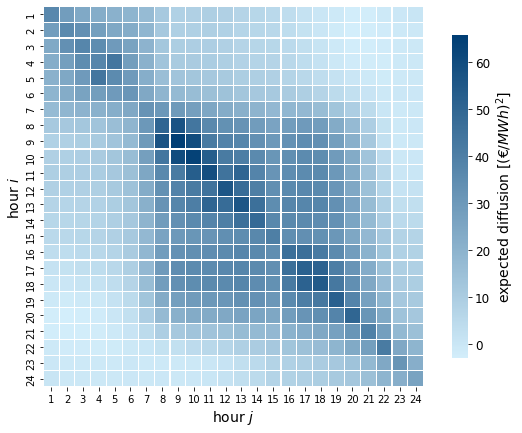

In [58]:
fig, ax = plt.subplots(figsize=(10, 7))
aux_diff_matrix = pd.DataFrame(diff_matrix_kde)
aux_diff_matrix.index = range(1, 25)
aux_diff_matrix.columns = aux_diff_matrix.index
sns.heatmap(aux_diff_matrix, cmap=cmap_4, square=True, linewidths=0.1, 
            cbar_kws={"shrink": 0.85}, ax=ax)
ax.collections[0].colorbar.set_label('expected diffusion [$(€/MWh)^2$]', fontsize=14)
ax.collections[0].colorbar.ax.tick_params(labelsize=12) 
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel("hour $j$", fontsize=14)
ax.set_ylabel("hour $i$", fontsize=14)
fig.savefig("figures/paper/diffusion_matrix_kde.pdf", bbox_inches='tight')

In [59]:
aux_diff_matrix.loc[7:11, 7:11]

7          8          9          10         11
7   32.311128  30.402775  29.843020  27.702566  24.770585
8   30.402775  50.304697  57.283325  43.910343  36.368799
9   29.843020  57.283325  65.849852  60.269868  42.193395
10  27.702566  43.910343  60.269868  64.228436  53.425228
11  24.770585  36.368799  42.193395  53.425228  59.377403

In [60]:
np.abs(nearest_diff_matrix_kde - diff_matrix_kde).max()

7.370761146261927

In [61]:
np.linalg.eigvals(nearest_diff_matrix_kde)

array([5.22631911e+02, 1.91151558e+02, 1.06112870e+02, 4.97397760e+01,
       3.62999669e+01, 2.68232726e+01, 2.37656888e+01, 2.02801704e+01,
       1.47896498e+01, 1.37883756e+00, 1.93603451e+00, 1.31205873e+01,
       1.16595010e+01, 1.13719872e+01, 1.04495521e+01, 9.69267327e+00,
       9.52646286e+00, 4.43076235e+00, 6.78526547e+00, 6.02081859e+00,
       6.33991493e+00, 3.26775584e-13, 5.82681274e-13, 5.14195601e-13])

In [62]:
from scipy.linalg import sqrtm

In [63]:
sqrt_diff_matrix_kde = sqrtm(nearest_diff_matrix_kde)

In [64]:
diff = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

In [65]:
diff.get_value(x=np.array([]), t=24)

array([[ 5.09878351e+00,  2.14229626e+00,  1.21018606e+00,
         1.02861193e+00,  9.67463983e-01,  9.93675640e-01,
         8.98529458e-01,  4.67966242e-01,  1.62966209e-01,
         2.60424942e-01,  3.59951136e-01,  3.47049830e-01,
         2.19967725e-01,  2.27832750e-01,  1.77896843e-01,
         3.74756075e-02, -9.04008601e-02, -1.54733448e-01,
        -1.55405869e-01, -2.27107129e-01, -1.69165823e-01,
         1.63101762e-02,  4.54301193e-02,  1.09726955e-01],
       [ 2.14229626e+00,  4.22437109e+00,  2.70900842e+00,
         1.44488390e+00,  1.00622297e+00,  1.17677930e+00,
         1.01710259e+00,  4.23949969e-01,  2.05368526e-01,
         2.59723390e-01,  3.00302123e-01,  2.90241743e-01,
         2.03626344e-01,  1.81447990e-01,  1.90179651e-01,
         7.03215468e-02, -2.64422103e-02, -1.50206092e-01,
        -2.02408104e-01, -2.35509217e-01, -1.61523471e-01,
        -6.69363931e-02, -1.78495145e-02,  2.87398200e-02],
       [ 1.21018606e+00,  2.70900842e+00,  4.12573281e

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$

In [101]:
#x_df = s_kde.df[(s_kde.df["date"] >= "2020-12-10")].iloc[:24*6]
x_df = df_raw[df_raw["year"] == 2021].iloc[:24*6]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

In [102]:
drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

sqrt_diff_matrix_kde = sqrtm(cov_nearest(cov=diff_matrix_kde, threshold=1e-14))
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

em_5 = EulerMaruyama(num_sim=1000, periods=6, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

In [103]:
%%time
sim_df = em_5.simulate(x0=x_0, random_seed=124)
sim_df_kde = sim_df.copy(deep=True)

CPU times: user 527 ms, sys: 45 ms, total: 572 ms
Wall time: 919 ms


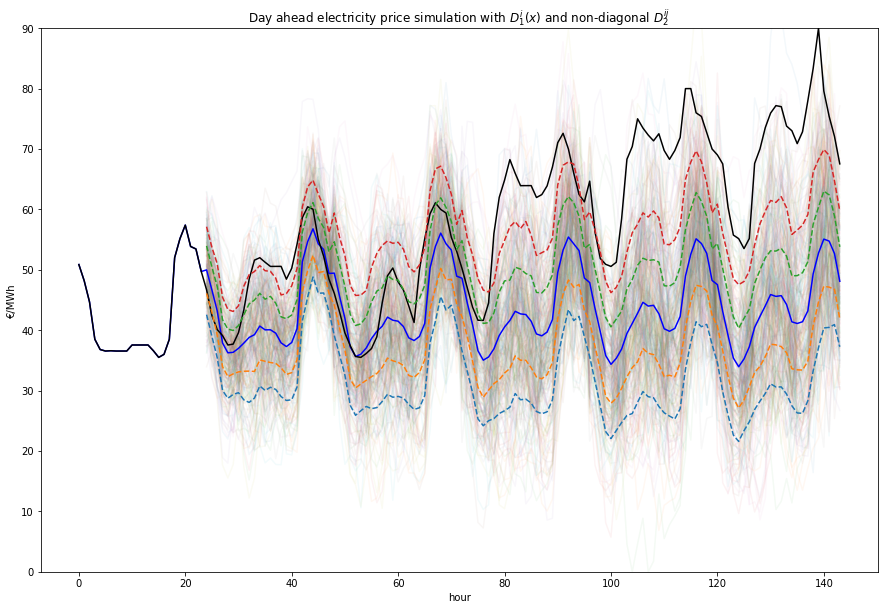

In [104]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_5.num_sim//4].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="blue", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="black", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 90)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

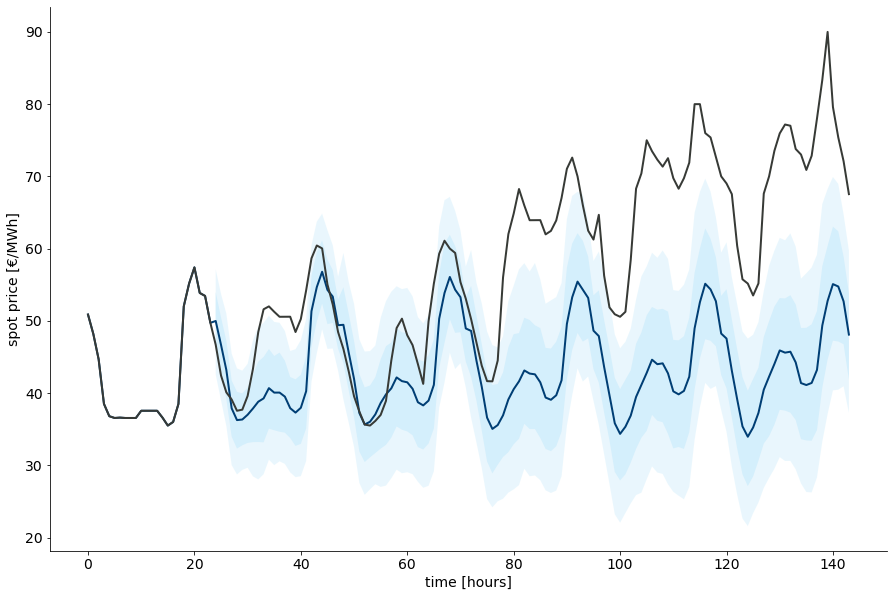

In [105]:
sim_dict = {"sim_df": sim_df_kde, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

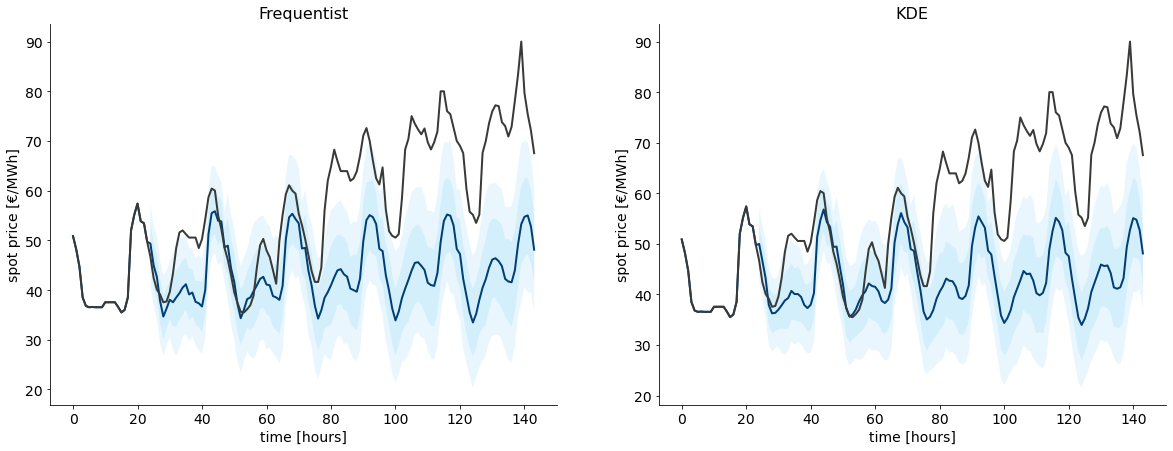

/home/antonio/Desktop/projects/electricity/stochastic/coefficients.py:53: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  return self.df.lookup(self.df.index, closest_x)
/home/antonio/Desktop/projects/electricity/stochastic/coefficients.py:34: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  return self.df.lookup(self.df.index, x)
/home/antonio/Desktop/projects/electricity/stochastic/coefficients.py:53: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  return self.df.lookup(self.df.index, closest_x)
/home/antonio/Desktop/projects/electricity/stochastic/coefficients.py:34: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt 

In [107]:
sim_dict_kde = {"sim_df": sim_df_kde, "actual_df": x_df_kde, "title": "KDE"}
plot_simulation_comparison(sim_left_dict=sim_dict_km, sim_right_dict=sim_dict_kde,
                           filename="figures/paper/em_km_kde_large_timestep_2021.pdf")

#### Simulation with $D_{1}^i(x)$ and non-diagonal constant $D_{2}^{ij}$ - higher time resolution

Doubt: Drift and diffusion were computed with d+1 - d step. Interaction with higher time resolution. 

In [ ]:
drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

em_6 = EulerMaruyama(num_sim=1000, periods=501, delta_t=0.01, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

In [ ]:
%%time
sim_df = em_6.simulate(x0=x_0, random_seed=124)

In [ ]:
indexes = []
dim = x_0.shape[0]
for i in np.arange((em_6.periods-1)*em_6.delta_t + 1):
    indexes += list(np.arange(int(i*dim*(1/em_6.delta_t)), int(i*dim*(1/em_6.delta_t)+dim)))

In [ ]:
sim_df = sim_df.loc[indexes].reset_index().iloc[:, 1:]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_5.num_sim//4].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 80)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")
plt.show()

In [ ]:
plot_simulation(sim_df=sim_df, actual_df=x_df, num_sim_show=250, ymax=80,
               title="Day ahead electricity price simulation with $D_1^i(x)$ and non-diagonal $D_2^{ij}$")

Compute price inflation as mean daily prices - mean drfit and learn this through a neural ODE